In [21]:
using Knet: Knet, dir, accuracy, progress, sgd, load, save, gc, Param, KnetArray, Data, minibatch, nll, relu, training, dropout
using Statistics
using Plots
using CUDA
using Random
using LinearAlgebra
using Knet
using Plots; default(fmt=:png,ls=:auto)
using ProgressBars


In [2]:
if CUDA.functional()
    atype = KnetArray{Float32};
else
    atype = Array{Float32};
end

KnetArray{Float32,N} where N

In [3]:
bids=["PA",
  "1C", "1D", "1H", "1S", "1N",
  "2C", "2D", "2H", "2S", "2N",
  "3C", "3D", "3H", "3S", "3N",
  "4C", "4D", "4H", "4S", "4N",
  "5C", "5D", "5H", "5S", "5N",
  "6C", "6D", "6H", "6S", "6N",
  "7C", "7D", "7H", "7S", "7N"];


# Random Deals and Hand Features
Hands are represented with 52-bit vectors and bidding history with 36-bit vectors.

In [4]:
## entries:   (1 2 3 4 5 6 7 8 9 10 11 12 13)--> spades 14 15 16 17 18 19 20 21 22 23 24 25 26
## correspnds (2 3 4 5 6 7 8 9 T  J  Q  K  A).. so on

function random_hand(;remaining=ones(52,1)) #input: remaininn deal,  output: a random hand 
    cards_in_deal=[j for j in 1:52 if remaining[j]==1]
    shuffle!(cards_in_deal)
    hand= [ifelse(j in cards_in_deal[1:13],1,0) for j in 1:52];
    return hand
end

function random_deal(hands=[])
    remaining = ones(52,1);
    all_hands=zeros(52,4)
    for i in 1:length(hands)                #write given pre-dealt hands
            remaining = remaining-hands[i];
            all_hands[:,i]=hands[i]
    end
    generated_hands=4-length(hands)
    for i in 1:generated_hands              #generate remaining hands
        hand=random_hand(remaining=remaining)
        remaining = remaining-hand;
        all_hands[:,i+length(hands)]=hand
    end
    
    return all_hands #returns 52x4 matrix each column is a hand, they are in order as N,S,E,W
end



#features

function hcp_of(hand;suit_seperated=false) #calculates the HCP of a hand both total or suit seperated
    points=[1,2,3,4]
    if suit_seperated
        return [dot(points,hand[10:13]),dot(points,hand[23:26]),dot(points,hand[36:39]),dot(points,hand[49:52])]
    end
    honours=hand[10:13]+hand[23:26]+hand[36:39]+hand[49:52]
    return dot(honours,points)
end

function distribution_of(hand) #returns the card number of each suit in the order S,H,D,C
   return [sum(hand[1:13]),sum(hand[14:26]),sum(hand[27:39]),sum(hand[40:52])] 
end

#tools

function human_readable(hand)
    to_cards=["2","3","4","5","6","7","8","9","T","J","Q","K","A"]
    suits=[]
    for i in 1:4
        suit=hand[13*(i-1)+1:13*i]
        cards= [to_cards[j] for j in 13:-1:1 if suit[j]==1]
        push!(suits,join(cards))
    end
    return suits
end


human_readable (generic function with 1 method)

# Deep Q-network Model

In [94]:
struct Chain
    layers
    Chain(layers...) = new(layers)
end
(c::Chain)(x) = (for l in c.layers; x = l(x); end; x)
(c::Chain)(x,y) = loss(c(x),y)
(c::Chain)(x::Tuple) = loss(c(x[1]),x[2])
(c::Chain)(d::Data) = mean(c(x,y) for (x,y) in d)

struct Dense
    w;
    b;
    f;
end

Dense(i::Int,o::Int,f=relu) = Dense(param(o,i),param0(o),f)
(l::Dense)(x) = (l.w * x .+ l.b)

dnn_init=Chain(Dense(52,128),Dense(128,128),Dense(128,128),Dense(128,36,identity));
dnn=Chain(Dense(52+36,128),Dense(128,128),Dense(128,128),Dense(128,36,identity));
println.(summary.((l.w,l.b)) for l in dnn_init.layers);


("128×52 Param{KnetArray{Float32,2}}", "128-element Param{KnetArray{Float32,1}}")
("128×128 Param{KnetArray{Float32,2}}", "128-element Param{KnetArray{Float32,1}}")
("128×128 Param{KnetArray{Float32,2}}", "128-element Param{KnetArray{Float32,1}}")
("36×128 Param{KnetArray{Float32,2}}", "36-element Param{KnetArray{Float32,1}}")


In [95]:
function loss(Q_value,cost)
    return mean((Q_value+cost.-1).^2)/2
end
function sgdupdate!(func, x,y; lr=0.1)
    fval = @diff func(x,y)
    for param in params(fval)
        ∇param = grad(fval, param)
        param .-= lr * ∇param
    end
    return value(fval)
end


sgdupdate! (generic function with 1 method)

In [81]:
Q1=Chain(Dense(52,128),Dense(128,128),Dense(128,128),Dense(128,36,identity));
Q2=Chain(Dense(52+36,128),Dense(128,128),Dense(128,128),Dense(128,36,identity));
Q3=Chain(Dense(52+36,128),Dense(128,128),Dense(128,128),Dense(128,36,identity));
Q4=Chain(Dense(52+36,128),Dense(128,128),Dense(128,128),Dense(128,36,identity));
Q5=Chain(Dense(52+36,128),Dense(128,128),Dense(128,128),Dense(128,36,identity));
Q6=Chain(Dense(52+36,128),Dense(128,128),Dense(128,128),Dense(128,36,identity));
Q=[Q1,Q2,Q3,Q4,Q5,Q6];

# Cost Array Calculation and Double Dummy Analysis (will be added)

In [96]:
function generate_cost(hands_NS,random_trial=5;random_cost=false)
    if random_cost
        return rand(52,1)
    end
    costs=zeros(52,1)
    for i in 1:random_trial
        deal=random_deal(hands)
        #---- generate cost vector here
        
        #-----
        costs +=costs
    end
    return costs./random_trial
end

generate_cost (generic function with 2 methods)

In [97]:
function generate_random_instances(size)
    data=Array{Float64,3}(undef,3,52,size)
    for i in 1:size
        deal=random_deal()
        data[1,:,i]=deal[:,1]
        data[2,:,i]=deal[:,2]
        data[3,:,i]=generate_cost(deal[:,1:2],random_cost=true)
    end
    return data
end
    

generate_random_instances (generic function with 1 method)

In [98]:
#hyper parameters
epsilon_greedy=0.05;
turn_depth=6;
learning_rate=0.1;
batch_size=50;
instance_size=1000;

# Baseline Algorithm

In [99]:
instances = generate_random_instances(instance_size);

costs=[]
iteration_size=1000
for i in 1:iteration_size
    instance= instances[:,:,rand(1:instance_size)]; #choose a random deal
    bidding_hist=zeros(36);
    for t in 1:turn_depth
        if t==1
            last_bid=1
        else
            last_bid=maximum(findall(x-> x==1,bidding_hist)) #the nature of an action
        end
        current_bid=rand(last_bid:36) #randomly bid a contract
        if last_bid == current_bid #if current bid is pass
            break;
        end
        bidding_hist[current_bid]=1;
    end
    
    contract=1
    try
        contract=findall(x-> x==1,bidding_hist)[1]
    catch
        contract=1
    end
    cost=instance[3,contract]   # cost of declaring this contract
    push!(costs,cost)
end

mean(costs)   # overall success of the baseline

0.5100376970336249

# Hand Reading From txt


In [100]:
function get_score(contract,trick_made,is_vul=false) # get the raw score of any contract
    trump=contract[2]
    trick_bid= parse(Int32,contract[1])+6
    level=parse(Int32,contract[1])
    made= trick_made >= trick_bid
    over_trick = trick_made - trick_bid
    if made
        if trump in ['H','S']
            contract_points=(trick_made-6)*30
            is_game=level >=4
        elseif trump in ['D','C']
            contract_points=(trick_made-6)*20
            is_game=level >=5
        else
            contract_points=(40+(trick_made-6-1)*30)
            is_game=level >=3
        end
        game_points=0
        slam_bonus=0
        part_score_bonus=0
        if is_game
            game_points=300+is_vul*200
        else
            part_score_bonus=50
        end
        if level==6
            slam_bonus=500+is_vul*250
        elseif level == 7
            slam_bonus=1000+is_vul*500
        end
        score= game_points+slam_bonus+part_score_bonus+contract_points
        return score
    else
        penalty=0
        if is_vul
            penalty=100*over_trick
        else
            penalty=50*over_trick
        end
        return penalty
    end
end

get_score (generic function with 2 methods)

In [101]:
function raw_score_to_imp(cost)
    cost=abs.(cost)
    if cost<=20
        return 0
    elseif cost<=40
        return 1
    elseif cost<=80
        return 2
    elseif cost<=120
        return 3
    elseif cost<=160
        return 4
    elseif cost<=210
        return 5
    elseif cost<=260
        return 6
    elseif cost<=310
        return 7
    elseif cost<=360
        return 8
    elseif cost<=420
        return 9
    elseif cost<=490
        return 10
    elseif cost<=590
        return 11
    elseif cost<=740
        return 12
    elseif cost<=890
        return 13
    elseif cost<=1090
        return 14
    elseif cost<=1290
        return 15
    elseif cost<=1490
        return 16
    elseif cost<=1740
        return 17
    elseif cost<=1990
        return 18
    elseif cost<=2240
        return 19
    elseif cost<=2490
        return 20
    elseif cost<=2990
        return 21
    elseif cost<=3490
        return 22
    elseif cost<=3990
        return 23
    else
        return 24
    end
end

raw_score_to_imp (generic function with 1 method)

In [102]:
cards_to_indices=Dict{String,Integer}("2"=>1,"3"=>2,"4"=>3,"5"=>4,"6"=>5,"7"=>6,"8"=>7,"9"=>8,"T"=>9,"J"=>10,"Q"=>11,"K"=>12,"A"=>13);
function PBN_to_vector(hand) # PBN formatted a hand is converted to 52-size vector
    raw_data=zeros(52);
    suits=split(hand,'.');
    for i in 1:4
        for card in suits[i]
            raw_data[(i-1)*13+cards_to_indices[string(card)]]=1;
        end
    end
    return raw_data
end

suit_order=Dict{Char,Integer}('N'=> 0,'S'=> 1,'H'=> 2,'D'=> 3,'C'=> 4);
function PBN_to_cost(dds) # PBN formatted a DDS-record is converted to (36,2)-size cost vector
    costs=zeros(36,2);
    for i in 2:36
        contract=bids[i];
        trump=contract[2];
        trick_bid= parse(Int32,contract[1])+6;
        # if north is the declarer then east is the leader
        trick_count_n=parse(Int32,dds[suit_order[trump]*4+2],base=16);
        # if south is the declarer then west is the leader
        trick_count_s=parse(Int32,dds[suit_order[trump]*4+4],base=16);
        costs[i,1]=get_score(contract,trick_count_n);
        costs[i,2]=get_score(contract,trick_count_s);
    end
    costs[:,1]= raw_score_to_imp.(costs[:,1] .- maximum(costs[:,1]))./25;
    costs[:,2]= raw_score_to_imp.(costs[:,2] .- maximum(costs[:,2]))./25;
    
    return costs
end

PBN_to_cost (generic function with 1 method)

Generate a data instance from a PBN-formatted txt 

In [103]:
file= open("test_hamza.txt","r");
lines=readlines(file);
deal_data=[]
for deal in lines
    north=PBN_to_vector(deal[18:33])
    south=PBN_to_vector(deal[52:67])
    costs=PBN_to_cost(deal[69:end])
    push!(deal_data,(north,south,costs))

end

training_set=deal_data[1:4000];
test_set=deal_data[4001:end];


In [104]:
function determine_target(cost,current_bid,method="penetrative")
    if method=="penetrative" 
        optimal_bid=findmin(cost)[2]
        cost[1:current_bid-1].= 1.2

        if optimal_bid >= current_bid
            cost[current_bid:optimal_bid].= 0
        end
        return cost
    end
    #to do implement classic bellman equation
    return cost
    
end

function explore(Q_network,state,current_bid,epsilon)
    q_values=Q_network(state)
    if rand()>epsilon
        bid=findmin(q_values)
        #print(Array(q_values))
        #println(bid)
        bid=bid[2]

    else
        bid= rand(current_bid:36)
    end 
    return bid
end

explore (generic function with 1 method)

# Main Learning Algorithm

In [177]:
function bid!(Q,deal,database_state,database_target,data_state_all_bid,epsilon_greedy)
    bidding_hist=zeros(36,1);
    instance=(deal[1],deal[2],bidding_hist);
    for t in 1:turn_depth
        if t==1
            current_bid=1;
            state=atype(reshape(instance[(t-1)%2+1],(52)));
        else
            b=findlast(x->x==1,bidding_hist);
            current_bid=b[1];
            state=atype(reshape(vcat(instance[(t-1)%2+1],instance[3]),(88)));  
        end
        #Algorithm P
        target=determine_target(deepcopy(deal[3][:,(t-1)%2+1]),current_bid);
        #Data for experience replay
        push!(database_state[t],state);
        push!(database_target[t],target);
        #exploration
        action=explore(Q[t],state,current_bid,epsilon_greedy);
        # current bid is pass----- 
        if action== current_bid
            break;
        end
            
        #Update bidding history
        bidding_hist[action]=1;
    end   
        push!(data_state_all_bid,(deal[1],deal[2],bidding_hist))

    return 
end

function bid_to_the_end(Q,deal_set,number_of_deals)
    database_state=[[],[],[],[],[],[]];
    database_target=[[],[],[],[],[],[]];
    for i in 1:number_of_deals
        bid!(Q,deal_set[rand(1:end)],database_state,database_target,0);
    end 
    return database_state, database_target ,data_state_all_bid
end

bid_to_the_end (generic function with 3 methods)

In [178]:
function train!(Q,training_set,test_set;iteration_size=1000,progress=true,epsilon_greedy=0.05, batchsize=50,learning_rate=0.1,periods=10,turn_depth=6)
    database_target_training=[[],[],[],[],[],[]];
    database_state_training=[[],[],[],[],[],[]];
    data_state_and_action=[[],[],[],[],[],[]];
    data_state_all_bid=[];
    history_of_Q=[];
    push!(history_of_Q,deepcopy(Q));
    
    if progress
        iterator= ProgressBar(1:iteration_size)
    else
        iterator= 1:iteration_size
    end
    for i in iterator
        bid!(Q,training_set[rand(1:end)],database_state_training,database_target_training,data_state_all_bid,epsilon_greedy)
        #Experience Replay
        for t in 1:turn_depth
            copy_database_target=copy(database_target_training[t]);
            copy_database_state=copy(database_state_training[t]);
            data=minibatch(hcat(copy_database_state...),hcat(copy_database_target...),batch_size,shuffle=true);
            if summary(data)[1]=='0'#if no minibatch
            else
                #take a single minibatch
                x,y=first(data);
                sgdupdate!(Q[t],x,y,lr=learning_rate);
            end
        end
        if i%periods==0
           push!(history_of_Q,deepcopy(Q));
        end
    end
   return history_of_Q,database_target_training,database_state_training,data_state_all_bid
    end;

    

In [234]:
function init()
    Q1=Chain(Dense(52,128),Dense(128,128),Dense(128,128),Dense(128,36,identity));
    Q2=Chain(Dense(52+36,128),Dense(128,128),Dense(128,128),Dense(128,36,identity));
    Q3=Chain(Dense(52+36,128),Dense(128,128),Dense(128,128),Dense(128,36,identity));
    Q4=Chain(Dense(52+36,128),Dense(128,128),Dense(128,128),Dense(128,36,identity));
    Q5=Chain(Dense(52+36,128),Dense(128,128),Dense(128,128),Dense(128,36,identity));
    Q6=Chain(Dense(52+36,128),Dense(128,128),Dense(128,128),Dense(128,36,identity));
    Q.=[Q1,Q2,Q3,Q4,Q5,Q6];
end
init()
history_of_Q,database_target_training,database_state_training,data_state_all_bid=train!(Q,training_set,test_set,iteration_size=2000,progress=true,periods=20);

100.0%┣█████████████████████████████████████┫ 2000/2000 [03:12<00:00, 10.4 it/s]


An instance of a decleration history

In [268]:
instance=data_state_all_bid[rand(1:end)]
println(human_readable(instance[1]))
println(human_readable(instance[2]))
for i in 1:36
    if instance[3][i]==1
        println(bids[i])
    end
end

Any["J2", "QJ75", "AJ3", "J832"]
Any["AK8", "K964", "82", "AK94"]
1S
2C
2H
3S
4H
7C


Calculate and Plot the Average Losses of every Epoch

In [247]:
test_losses=[[],[],[],[],[],[]];
train_losses=[[],[],[],[],[],[]];

for epoch in ProgressBar(history_of_Q)
    database_state, database_target= bid_to_the_end(epoch,training_set,100)
    database_state_test, database_target_test= bid_to_the_end(epoch,test_set,100)
    for i in 1:6
        data=minibatch(hcat(database_state[i]...),hcat(database_target[i]...),batch_size,shuffle=true);
        push!(train_losses[i],epoch[i](first(data)));
        data=minibatch(hcat(database_state_test[i]...),hcat(database_target_test[i]...),batch_size,shuffle=true);
        push!(test_losses[i],epoch[i](first(data)));
        
    end
end

100.0%┣████████████████████████████████████████┫ 101/101 [00:31<00:00, 3.2 it/s]


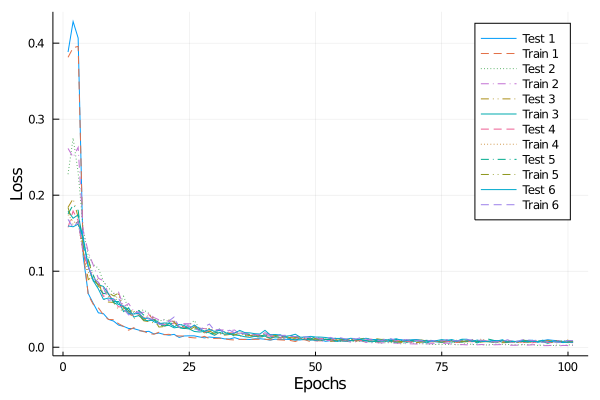

In [248]:
# Comparison to MLP shows faster convergence, better generalization
plot(test_losses[1],label="Test 1",xlabel="Epochs",ylabel="Loss")
plot!(train_losses[1],label="Train 1",xlabel="Epochs",ylabel="Loss")
plot!(test_losses[2],label="Test 2",xlabel="Epochs",ylabel="Loss")
plot!(train_losses[2],label="Train 2",xlabel="Epochs",ylabel="Loss")
plot!(test_losses[3],label="Test 3",xlabel="Epochs",ylabel="Loss")
plot!(train_losses[3],label="Train 3",xlabel="Epochs",ylabel="Loss")
plot!(test_losses[4],label="Test 4",xlabel="Epochs",ylabel="Loss")
plot!(train_losses[4],label="Train 4",xlabel="Epochs",ylabel="Loss")
plot!(test_losses[5],label="Test 5",xlabel="Epochs",ylabel="Loss")
plot!(train_losses[5],label="Train 5",xlabel="Epochs",ylabel="Loss")
plot!(test_losses[6],label="Test 6",xlabel="Epochs",ylabel="Loss")
plot!(train_losses[6],label="Train 6",xlabel="Epochs",ylabel="Loss")

Opening bid with a random hand

In [249]:
example_bids=[]
sample_size=1000
for i in 1:sample_size
    state= deal_data[rand(1:end)]
    current_bid=1
    action=explore(Q[1],atype(state[1]),current_bid,0)
    push!(example_bids,(state[1],action,state[2],state[3]))
end

In [260]:
instance=example_bids[rand(1:end)]
println(human_readable(instance[1]))
println(human_readable(instance[3]))
println(instance[4][:,1])
println(bids[instance[2]])
println(bids[maximum(findall(x->x==0,instance[4][:,1]))])

Any["AQT2", "J987", "2", "KJ82"]
Any["94", "2", "JT984", "A6543"]
[0.12, 0.0, 0.16, 0.24, 0.2, 0.16, 0.0, 0.2, 0.28, 0.24, 0.2, 0.0, 0.24, 0.32, 0.28, 0.24, 0.16, 0.28, 0.36, 0.32, 0.28, 0.2, 0.32, 0.4, 0.36, 0.32, 0.24, 0.36, 0.44, 0.4, 0.36, 0.28, 0.4, 0.44, 0.44, 0.4]
7D
3C
